## ‣ Introduction

Este projeto possui como objetivo estruturar uma rede neural e treiná-la a partir do conjunto de dados CIFAR-10. A fim de obter uma accuracy superior à 70% na atividade de classificação.

Algumas resultados obtidos por benchmark incluem:

‣ 78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

‣ 90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

‣ 96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

‣ 99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

‣ 98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

## ‣ Imports

In [1]:
## This cell contains the essential imports

import torch

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

import torchvision

import torchvision.transforms as transforms

from torchvision import models

import matplotlib.pyplot as plt

import numpy as np

from collections import OrderedDict

In [14]:
%matplotlib inline

## ‣ Loading the Dataset

Nesta etapa do projeto o conjunto de dados "CIFAR-10" é obtido a partir do módulo torchvision. E segmentado em subconjuntos, sendo eles: Treino, teste e validação.

Assim, como algumas transformações são definidas.

Documentação: [CIFAR](https://pytorch.org/vision/stable/datasets.html#cifar)

In [2]:
# Define transforms

train_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

validation_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Create training set and define training dataloader

data_train = torchvision.datasets.CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = train_transforms
)    
    
train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size = 64,
    shuffle = True
)

# Create test set and define test dataloader

data_test = torchvision.datasets.CIFAR10(
    root = './data',
    train = False,
    download = True,
    transform = test_transforms
)

test_loader = torch.utils.data.DataLoader(
    data_test,
    batch_size = 64,
    shuffle = True
)

# Validation set and validation dataloader

data_validation = torchvision.datasets.CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = validation_transforms
) 

validation_loader = torch.utils.data.DataLoader(
    data_test,
    batch_size = 64,
    shuffle = True
)

# The 10 classes in the dataset

classes = (
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## ‣ Exploring the Dataset

Nesta etapa ocorre uma atividade de exploração dos dados obtidos.

A função `show5` recebe um data loader como um argumento e retorna algumas das imagens dentro do CIFAR-10.

Obs: Devido a normalização das imagens devido às transformações aplicadas, elas aparentam estar "distorcidas".

In [3]:
def show5(img_loader):
    
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    
    labels = batch[1][0:5]
    
    images = batch[0][0:5]
    
    for i in range(5):
    
        print(classes[labels[i]])
    
        image = images[i].numpy()
        
        plt.imshow(np.rot90(image.T, k=3))
        
        plt.show()

cat


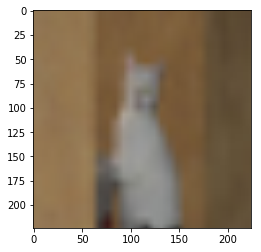

truck


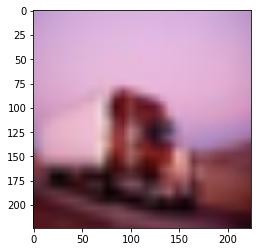

plane


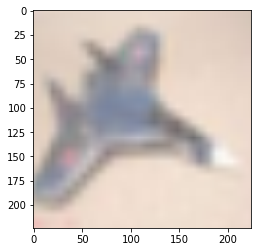

bird


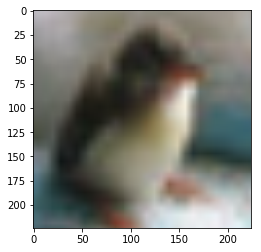

dog


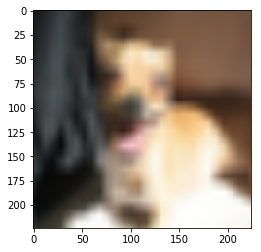

In [4]:
# Explore data

show5(test_loader)

## ‣ Building the Neural Network

Com intuito de obter a accuracy desejada para esse projeto, eu optei por utilizar o conceito de transfer learning a partir de um módulo pré-treinado, o VGG16.

Além disso, eu aumentei a sua complexidade com a adição de um novo classificador, o qual compõem um conjunto de linear layers e dropouts.

In [5]:
model = models.vgg16(pretrained = True)

model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:33<00:00, 16689986.48it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
for param in model.parameters():
    
    param.requires_grad = False

In [7]:
model_classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(p = 0.2),
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Dropout(p = 0.2),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.LogSoftmax(dim = 1)
)

model_classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2)
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1024, out_features=512, bias=True)
  (9): LogSoftmax()
)

In [8]:
model.classifier = model_classifier

Especificando uma loss function e um optimizer.

In [9]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr = 0.001
)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## ‣ Running the Neural Network

In [11]:
print_every = 10

epochs = 1

training_loss_list = []

validation_loss_list = []

validation_accuracy_list = []

for epoch in range(epochs):
    
    running_loss = 0
    
    steps = 0
    
    for images, labels in train_loader:
        
        images = images.to(device)
        
        labels = labels.to(device)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        steps += 1
        
        if (steps % print_every == 0):
            
            model.eval()
            
            validation_loss = 0
            
            validation_accuracy = 0
            
            with torch.no_grad():
                
                for images2, labels2 in validation_loader:
                    
                    images2 = images2.to(device)
        
                    labels2 = labels2.to(device)
                    
                    outputs2 = model(images2)
                    
                    validation_loss += criterion(outputs2, labels2)
                    
                    ps = torch.exp(outputs2).data
                    
                    equals = (labels2.data == ps.max(1)[1])
                    
                    validation_accuracy += equals.type_as(torch.FloatTensor()).mean()
                    
            print('--------------------------------------------')
            
            print(f'Epoch: {epoch + 1}/{epochs}')
            
            print(f'Training Loss: { running_loss / print_every }')
                
            print(f'Validation Loss: { validation_loss / len(validation_loader) }')
                
            print(f'Validation Accuracy: { validation_accuracy / len(validation_loader) }')
            
            training_loss_list.append(running_loss / print_every)

            validation_loss_list.append(validation_loss / len(validation_loader))

            validation_accuracy_list.append(validation_accuracy / len(validation_loader))
            
            running_loss = 0
            
            model.train()

--------------------------------------------
Epoch: 1/1
Training Loss: 3.9209336280822753
Validation Loss: 2.8433265686035156
Validation Accuracy: 0.20183120667934418
--------------------------------------------
Epoch: 1/1
Training Loss: 2.7195834159851073
Validation Loss: 2.288520336151123
Validation Accuracy: 0.15555334091186523
--------------------------------------------
Epoch: 1/1
Training Loss: 2.250050115585327
Validation Loss: 1.989297866821289
Validation Accuracy: 0.21685907244682312
--------------------------------------------
Epoch: 1/1
Training Loss: 2.0746519804000854
Validation Loss: 1.8232027292251587
Validation Accuracy: 0.3086186349391937
--------------------------------------------
Epoch: 1/1
Training Loss: 1.9221285820007323
Validation Loss: 1.5327085256576538
Validation Accuracy: 0.4552149772644043
--------------------------------------------
Epoch: 1/1
Training Loss: 1.9131970763206483
Validation Loss: 1.7106300592422485
Validation Accuracy: 0.34205812215805054
---

Plot the training loss (and validation loss/accuracy, if recorded).

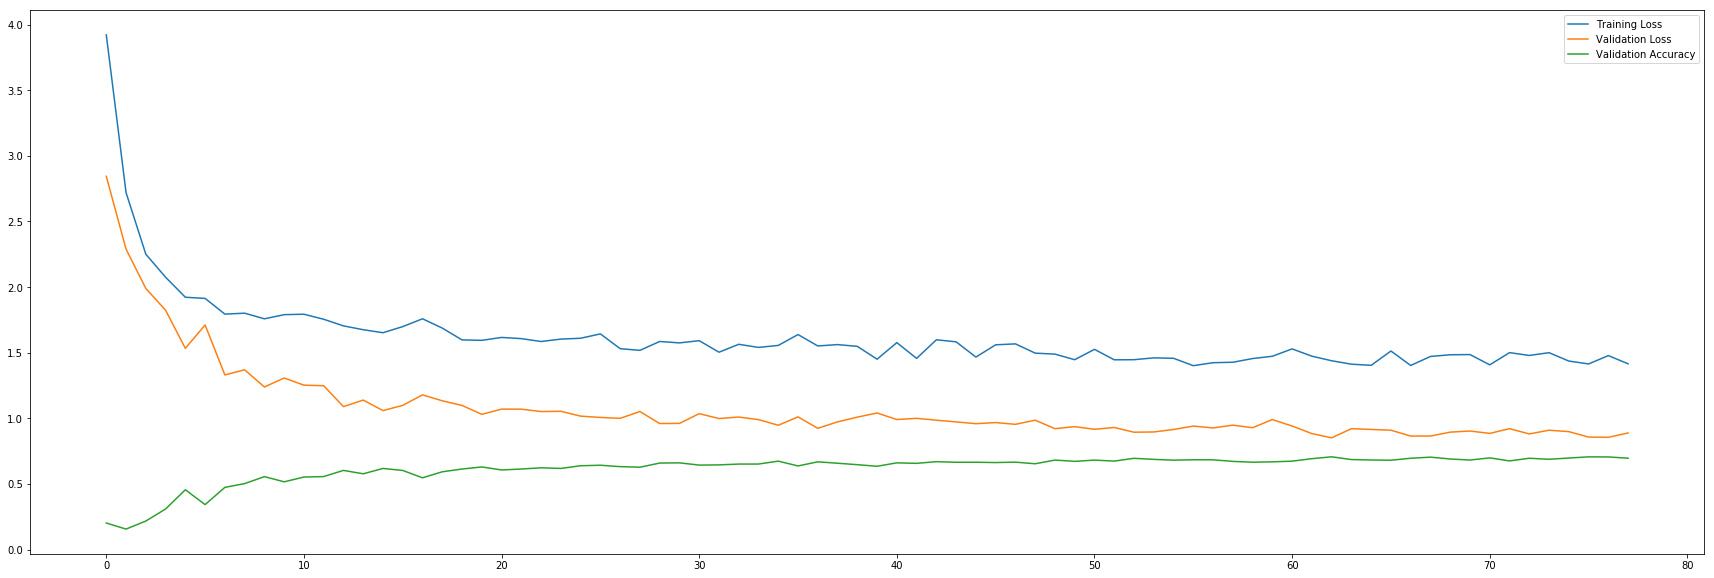

In [15]:
plt.rcParams["figure.figsize"] = (30, 10)

plt.plot(training_loss_list, label = 'Training Loss')

plt.plot(validation_loss_list, label = 'Validation Loss')

plt.plot(validation_accuracy_list, label = 'Validation Accuracy')

plt.legend()

plt.show()

## ‣ Testing the model

In [12]:
test_accuracy = 0

test_loss = 0

with torch.no_grad():
    
    model.eval()

    for images, labels in test_loader:
        
        images = images.to(device)
        
        labels = labels.to(device)
        
        outputs = model(images)
            
        test_loss += criterion(outputs, labels)
            
        ps = torch.exp(outputs).data
                    
        equals = (labels.data == ps.max(1)[1])
                    
        test_accuracy += equals.type_as(torch.FloatTensor()).mean()
        
    
print(f'Training Loss: { test_loss / len(test_loader) }')

print(f'Test accuracy: { test_accuracy / len(test_loader) }')

Training Loss: 0.8436970710754395
Test accuracy: 0.709792971611023


## ‣ Saving the model

O modelo treinado será armanezado e poderá ser utilizado em usos futuros.

In [13]:
torch.save(model.state_dict(), 'checkpoint.pth')

## ‣ Conclusion

O projeto teve o seu objetivo principal alcançado, uma vez que a rede neural treinada foi capaz de obter uma accuracy de 70,98%.

Porém, ela está longe de modelos de alta performance, tais como: Maxout network, Wide residual networks e GPipe.

Como é possível observar durante o treinamento, um número maior de epochs não terá um peso expresso no aumento da performance do modelo atual.

Sendo recomendado novas features, tais como: Residual blocks e skip connections.